<a href="https://colab.research.google.com/github/MikeManzi/multimodel-data-preprocessing/blob/main/Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from skimage.feature import hog
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import os
import glob


ROOT = Path('.')
IMAGES_DIR = ROOT / 'sample_data/images'
OUTPUT_CSV = ROOT / 'image_features.csv'

Found 4 images with 'neutral' in their name:
  - Best-neutral.jpg
  - Carine-neutral.jpg
  - David-neutral.jpg
  - Mike-neutral.jpg


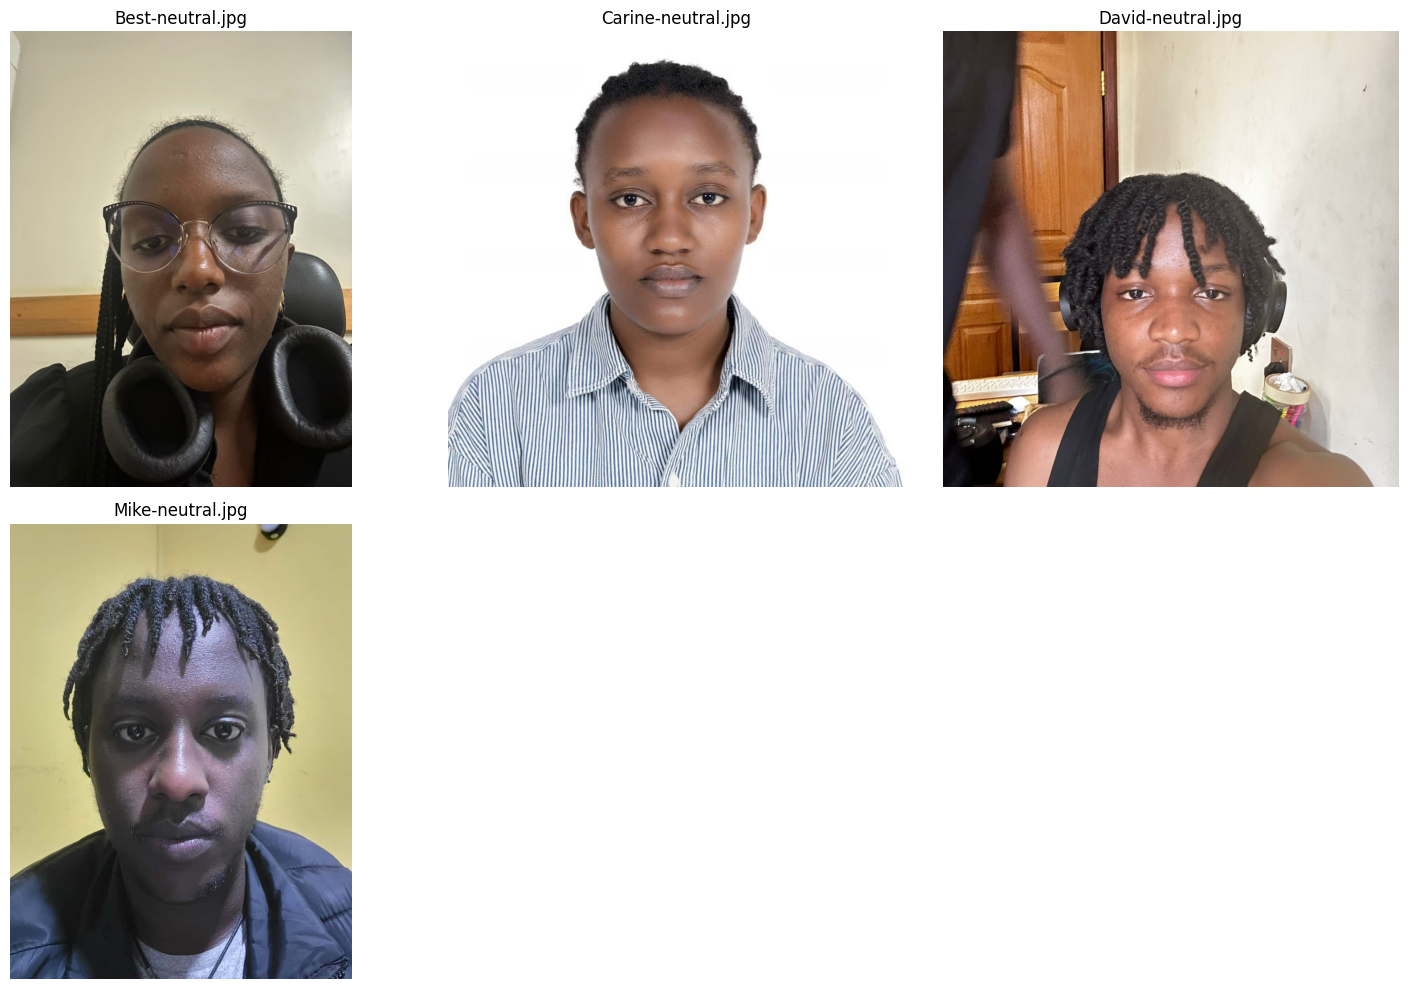

In [ ]:
IMAGES_DIR = ROOT / '../images'

neutral_images = []
for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
    pattern = str(IMAGES_DIR / f"*neutral*{ext}")
    neutral_images.extend(glob.glob(pattern))

print(f"Group members sample images")
for img_path in neutral_images:
    print(f"  - {os.path.basename(img_path)}")

if neutral_images:
    n_images = len(neutral_images)
    cols = min(3, n_images)  # Max 3 columns
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    
    if n_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if n_images > 1 else [axes]
    else:
        axes = axes.flatten()
    
    for i, img_path in enumerate(neutral_images):
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(os.path.basename(img_path), fontsize=12)
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading\n{os.path.basename(img_path)}\n{str(e)}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No images with 'neutral' in their name were found.")

In [ ]:
def get_image_files(images_dir):
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in extensions:
        image_files.extend(list(images_dir.glob(ext)))
    return sorted(image_files)

FIXED_SIZE = (128, 128)

def apply_augmentations(image):
    """
    Enhanced augmentation function - generates 15 variations per image
    Replace your old apply_augmentations() with this one
    """
    augmentations = []

    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = image.resize(FIXED_SIZE, Image.Resampling.LANCZOS)

    # 1. Original
    augmentations.append((image.copy(), 'original'))

    # 2-5. Rotations (4 variations)
    augmentations.append((image.rotate(15, expand=False), 'rot15'))
    augmentations.append((image.rotate(-15, expand=False), 'rot-15'))
    augmentations.append((image.rotate(30, expand=False), 'rot30'))
    augmentations.append((image.rotate(90, expand=False), 'rot90'))

    # 6-7. Flips (2 variations)
    augmentations.append((ImageOps.mirror(image), 'flip_h'))
    augmentations.append((ImageOps.flip(image), 'flip_v'))

    # 8. Grayscale
    gray_img = image.convert('L').convert('RGB')
    augmentations.append((gray_img, 'grayscale'))

    # 9-10. Brightness variations (2 variations)
    enhancer = ImageEnhance.Brightness(image)
    augmentations.append((enhancer.enhance(0.7), 'bright_dark'))
    augmentations.append((enhancer.enhance(1.3), 'bright_light'))

    # 11-12. Contrast variations (2 variations)
    enhancer = ImageEnhance.Contrast(image)
    augmentations.append((enhancer.enhance(0.8), 'contrast_low'))
    augmentations.append((enhancer.enhance(1.2), 'contrast_high'))

    # 13. Blur
    augmentations.append((image.filter(ImageFilter.GaussianBlur(radius=1)), 'blur'))

    # 14. Sharpen
    augmentations.append((image.filter(ImageFilter.SHARPEN), 'sharpen'))

    # 15. Add slight noise
    img_array = np.array(image)
    noise = np.random.normal(0, 10, img_array.shape).astype(np.uint8)
    noisy_img = Image.fromarray(np.clip(img_array + noise, 0, 255).astype(np.uint8))
    augmentations.append((noisy_img, 'noise'))

    return augmentations
def extract_color_histogram(image, bins=16):
    if image.mode != 'RGB':
        image = image.convert('RGB')

    img_array = np.array(image)
    hist_features = []

    for channel in range(3):
        hist, _ = np.histogram(img_array[:,:,channel], bins=bins, range=(0, 255), density=True)
        hist_features.extend(hist)

    return np.array(hist_features)

def extract_hog_features(image):
    if image.mode == 'RGB':
        gray_array = rgb2gray(np.array(image))
    else:
        gray_array = np.array(image.convert('L')) / 255.0

    features = hog(
        gray_array,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True
    )

    return features

print("Feature extraction functions defined.")
print(f"Fixed image size: {FIXED_SIZE}")
print(f"Expected color histogram features: {16 * 3}")
print(f"Expected HOG features: {((128//16-1)//2) * ((128//16-1)//2) * 9}")


Feature extraction functions defined.
Fixed image size: (128, 128)
Expected color histogram features: 48
Expected HOG features: 81


In [4]:
def process_all_images():
    image_files = get_image_files(IMAGES_DIR)
    print(f"Found {len(image_files)} images to process")

    all_data = []
    expected_feature_count = None

    for img_path in tqdm(image_files, desc="Processing images"):
        try:
            image = Image.open(img_path)
            filename = img_path.name

            augmentations = apply_augmentations(image)

            for aug_image, aug_type in augmentations:
                assert aug_image.size == FIXED_SIZE, f"Image size mismatch: {aug_image.size} != {FIXED_SIZE}"

                color_hist = extract_color_histogram(aug_image)
                hog_feats = extract_hog_features(aug_image)

                combined_features = np.concatenate([color_hist, hog_feats])

                if expected_feature_count is None:
                    expected_feature_count = len(combined_features)
                    print(f"Feature vector length: {expected_feature_count}")
                else:
                    assert len(combined_features) == expected_feature_count, f"Feature count mismatch: {len(combined_features)} != {expected_feature_count}"

                row_data = {
                    'filename': filename,
                    'augmentation': aug_type,
                    'width': aug_image.width,
                    'height': aug_image.height
                }

                for i, feat_val in enumerate(combined_features):
                    row_data[f'feature_{i}'] = feat_val

                all_data.append(row_data)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    df = pd.DataFrame(all_data)

    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    nan_count = df[feature_cols].isna().sum().sum()
    print(f"NaN values in features: {nan_count}")

    df.to_csv(OUTPUT_CSV, index=False)

    print(f"Processing complete!")
    print(f"Total rows: {len(df)}")
    print(f"Features per image: {len(feature_cols)}")
    print(f"CSV saved to: {OUTPUT_CSV}")

    return df

df_results = process_all_images()


Found 11 images to process


Processing images:   0%|          | 0/11 [00:00<?, ?it/s]

Feature vector length: 1812


Processing images: 100%|██████████| 11/11 [00:01<00:00,  7.60it/s]



NaN values in features: 0
Processing complete!
Total rows: 165
Features per image: 1812
CSV saved to: image_features.csv
Processing complete!
Total rows: 165
Features per image: 1812
CSV saved to: image_features.csv


In [5]:
print("DataFrame Info:")
print(f"Shape: {df_results.shape}")
print(f"Columns: {list(df_results.columns[:10])}...")  # Show first 10 columns

print("\nFirst few rows:")
display(df_results.head())

print("\nAugmentation counts:")
print(df_results['augmentation'].value_counts())

if OUTPUT_CSV.exists():
    print(f"\nCSV file successfully created: {OUTPUT_CSV}")
    print(f"File size: {OUTPUT_CSV.stat().st_size} bytes")
else:
    print(f"\nCSV file was not created!")

print(f"\nProcessing complete!")


DataFrame Info:
Shape: (165, 1816)
Columns: ['filename', 'augmentation', 'width', 'height', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']...

First few rows:


,filename,augmentation,width,height,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_1802,feature_1803,feature_1804,feature_1805,feature_1806,feature_1807,feature_1808,feature_1809,feature_1810,feature_1811
0,Best-neutral.jpg,original,128,128,0.006051,0.006074,0.003952,0.002876,0.003037,0.003512,...,0.000690,0.043561,0.126216,0.109087,0.143499,0.344723,0.215184,0.039635,0.034399,0.010474
1,Best-neutral.jpg,rot15,128,128,0.011393,0.004603,0.003581,0.002757,0.002987,0.003542,...,0.207525,0.006357,0.011058,0.056438,0.002696,0.135515,0.015361,0.008717,0.000000,0.000000
2,Best-neutral.jpg,rot-15,128,128,0.011500,0.005093,0.003309,0.002727,0.002960,0.003489,...,0.037085,0.230879,0.045679,0.146914,0.031411,0.009203,0.005513,0.006728,0.040514,0.082855
3,Best-neutral.jpg,rot30,128,128,0.013955,0.004262,0.003102,0.002669,0.002972,0.003458,...,0.010725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Best-neutral.jpg,rot90,128,128,0.006051,0.006074,0.003952,0.002876,0.003037,0.003512,...,0.328049,0.063561,0.038447,0.017445,0.023641,0.033754,0.032575,0.161954,0.318871,0.086670



Augmentation counts:
augmentation
original         11
rot15            11
rot-15           11
rot30            11
rot90            11
flip_h           11
flip_v           11
grayscale        11
bright_dark      11
bright_light     11
contrast_low     11
contrast_high    11
blur             11
sharpen          11
noise            11
Name: count, dtype: int64

CSV file successfully created: image_features.csv
File size: 5866418 bytes

Processing complete!
